# DaCe with Explicit Dataflow in Python

In this tutorial, we will use the explicit dataflow specification in Python to construct DaCe programs.

In [1]:
import dace

Explicit dataflow is a Python-based syntax that is close to defining SDFGs. In explicit ` @dace.program `s, the code (Tasklets) and memory movement (Memlets) are specified separately, as we show below.

## Matrix Transposition

We begin with a simple example, transposing a matrix (out-of-place). 

First, since we do not know what the matrix sizes will be, we define symbolic sizes:

In [2]:
M = dace.symbol('M')
N = dace.symbol('N')

We now proceed to define the data-centric part of the application (i.e., the part that can be optimized by DaCe). It is a simple function which, when called, invokes the compilation and optimization procedure. It can also be compiled explicitly, as we show in the next example.

DaCe programs use explicit types, so that they can be compiled. We provide a numpy-compatible set of types that can define N-dimensional tensors. For example, `dace.int64` defines a 64-bit signed integer scalar, and `dace.float32[133,8]` defines a 133-row and 8-column 2D array.

In [3]:
@dace.program
def transpose(A: dace.float32[M, N], B: dace.float32[N, M]):
    # Inside the function we will define a tasklet in a map, which is shortened
    # to dace.map. We define the map range in the arguments:
    @dace.map
    def mytasklet(i: _[0:M], j: _[0:N]):
        # Pre-declaring the memlets is required in explicit dataflow, tasklets
        # cannot use any external memory apart from data flowing to/from it.
        a << A[i,j]  # Input memlet (<<)
        b >> B[j,i]  # Output memlet (>>)
        
        # The code
        b = a

And that's it! We will now define some regression test using numpy:

In [4]:
import numpy as np
A = np.random.rand(37, 11).astype(np.float32)
expected = A.transpose()
# Define an array for the output of the dace program
B = np.random.rand(11, 37).astype(np.float32)

Before we call `transpose`, we can inspect the SDFG:

Automatically applied 1 strict state fusions and removed 0 redundant arrays.


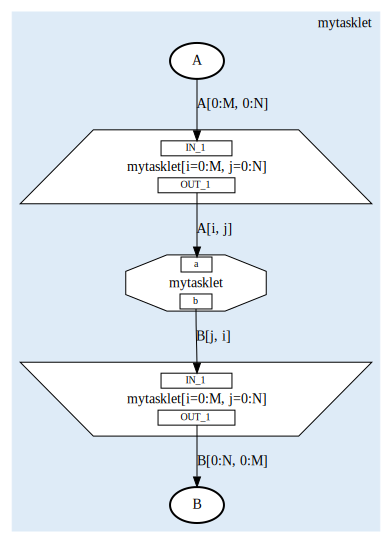

In [5]:
sdfg = transpose.to_sdfg()
sdfg

We can now call `transpose` directly, or using the SDFG we created. When calling `transpose`, we need to feed the symbols as well as the arguments (since the arrays are `numpy` rather than symbolic `dace` arrays, see below tutorials). When prompted for transformations, we will now just press the "Enter" key to skip them.

In [6]:
sdfg(A=A, B=B, M=A.shape[0], N=A.shape[1])

0. Pattern FPGATransformSDFG in transpose
1. Pattern FPGATransformState in mytasklet
2. Pattern GPUTransformState in transpose
3. Pattern NestSDFG in transpose
4. Pattern FPGATransformMap in mytasklet[i=0:M, j=0:N]
5. Pattern GPUTransformLocalStorage in mytasklet[i=0:M, j=0:N]
6. Pattern GPUTransformMap in mytasklet[i=0:M, j=0:N]
7. Pattern MapExpansion in mytasklet: ['i', 'j']
8. Pattern OrthogonalTiling in mytasklet: ['i', 'j']
9. Pattern StripMining in mytasklet: ['i', 'j']
Select the pattern to apply (0 - 9 or name$id): 
You did not select a valid option. Quitting optimization ...
-- Configuring done
-- Generating done
-- Build files have been written to: /path/to/dace/tutorials/.dacecache/transpose/build

[ 50%] Built target dacestub
Scanning dependencies of target transpose
[ 75%] Building CXX object CMakeFiles/transpose.dir/path/to/dace/tutorials/.dacecache/transpose/src/cpu/transpose.cpp.o
[100%] Linking CXX shared library libtranspose.so
[100%] Built target transpose



0

In [7]:
print('Difference:', np.linalg.norm(expected - B))

Difference: 0.0


## Query (using Streams)

In this example, we will use the Stream construct and symbolic dace ND arrays to create a simple parallel filter. We first define a symbolic size and a symbolically-sized array:

In [8]:
N = dace.symbol('N')

storage = dace.ndarray(shape=[N], dtype=dace.int32)
# The size of "output" will actually be lesser or equal to N, but we need to 
# statically allocate the memory.
output = dace.ndarray(shape=[N], dtype=dace.int32)
# The size is a scalar
output_size = dace.scalar(dtype=dace.uint32)

As with `transpose`, the DaCe program also consists of a tasklet nested in a Map, but also includes a Stream (to which we push outputs as necessary) that is directly connected to the output array, as well as a conflict-resolution output (because all tasklets in the map write to the same address:

In [9]:
@dace.program
def query(data: dace.int32[N], output: dace.int32[N], outsz: dace.int32[1], 
          threshold: dace.int32):
    # Define a local, unbounded (buffer_size=0) stream
    S = dace.define_stream(dace.int32, 0)
    
    # Define a memlet from S to the output
    S >> output
    
    # Filtering tasklet
    @dace.map
    def filter(i: _[0:N]):
        a << data[i]
        # Writing to S (no location necessary) a dynamic number of times (-1)
        out >> S(-1)
        # Writing to outsz dynamically (-1), if there is a conflict, we will sum the results
        osz >> outsz(-1, lambda a,b: a+b)   
        
        if a > threshold:
            # Pushing to a stream or writing with a conflict use the assignment operator
            out = a
            osz = 1

We can compile `query` without defining anything further. However, before we call `query`, we will need to set the symbol sizes.

In [10]:
qfunc = query.compile()

Automatically applied 1 strict state fusions and removed 0 redundant arrays.
0. Pattern FPGATransformSDFG in query
1. Pattern FPGATransformState in filter
2. Pattern GPUTransformState in query
3. Pattern NestSDFG in query
4. Pattern FPGATransformMap in filter[i=0:N]
5. Pattern GPUTransformLocalStorage in filter[i=0:N]
6. Pattern GPUTransformMap in filter[i=0:N]
7. Pattern MPITransformMap in filter
8. Pattern MapToForLoop in filter: ['i']
9. Pattern OrthogonalTiling in filter: ['i']
10. Pattern StripMining in filter: ['i']
11. Pattern Vectorization in 1 -> 2 -> 3
Select the pattern to apply (0 - 11 or name$id): 
You did not select a valid option. Quitting optimization ...
-- Configuring done
-- Generating done
-- Build files have been written to: /path/to/dace/tutorials/.dacecache/query/build

[ 50%] Built target dacestub
Scanning dependencies of target query
[ 75%] Building CXX object CMakeFiles/query.dir/path/to/dace/tutorials/.dacecache/query/src/cpu/query.cpp.o
/path/to/dace/tutoria

In [11]:
N.set(255)
thres = 50

In [12]:
# Define some random integers and zero outputs
import numpy as np
storage[:] = np.random.randint(0, 100, size=N.get())
output_size[0] = 0
output[:] = np.zeros(N.get()).astype(np.int32)

# Compute expected output using numpy
expected = storage[np.where(storage > thres)]

Here we will just use the Python function prototype to call the code, since we do not invoke it through the SDFG:

In [13]:
qfunc(storage, output, output_size, thres)
output_size

ndarray([131], dtype=uint32)

In [14]:
filtered_output = output[:output_size[0]]
# Sorting outputs to avoid concurrency-based reordering
print('Difference:', np.linalg.norm(np.sort(expected) - np.sort(filtered_output)))

Difference: 0.0
